# AI-Powered Productivity & Workflow Agent
### Built with Vertex AI & Gemini Flash - Vertex AI sprint


This project is an AI-powered workflow automation assistant designed to enhance productivity by leveraging Google Vertex AI, Gemini Flash, and Generative AI Cloud Functions. The AI acts as an intelligent agent that streamlines repetitive tasks, automates decision-making, and integrates with existing tools to improve efficiency.
-----------------------------------------------------------------------
This script implements an AI-powered productivity and workflow agent using Google Cloud's Vertex AI, Gemini models, and Cloud Functions. The agent provides three main capabilities:
1. Email Draft Generation: Automatically generates draft responses to emails
2. Research Paper Summarization: Creates comprehensive summaries of research papers
3. Code Visualization: Generates visual representations of code using Google's Imagen API

Setup Instructions
1. Ensure you have a Google Cloud account and project set up
2. Enable Vertex AI API and Cloud Functions API in your project
3. Create a service account with appropriate permissions
4. Install required dependencies

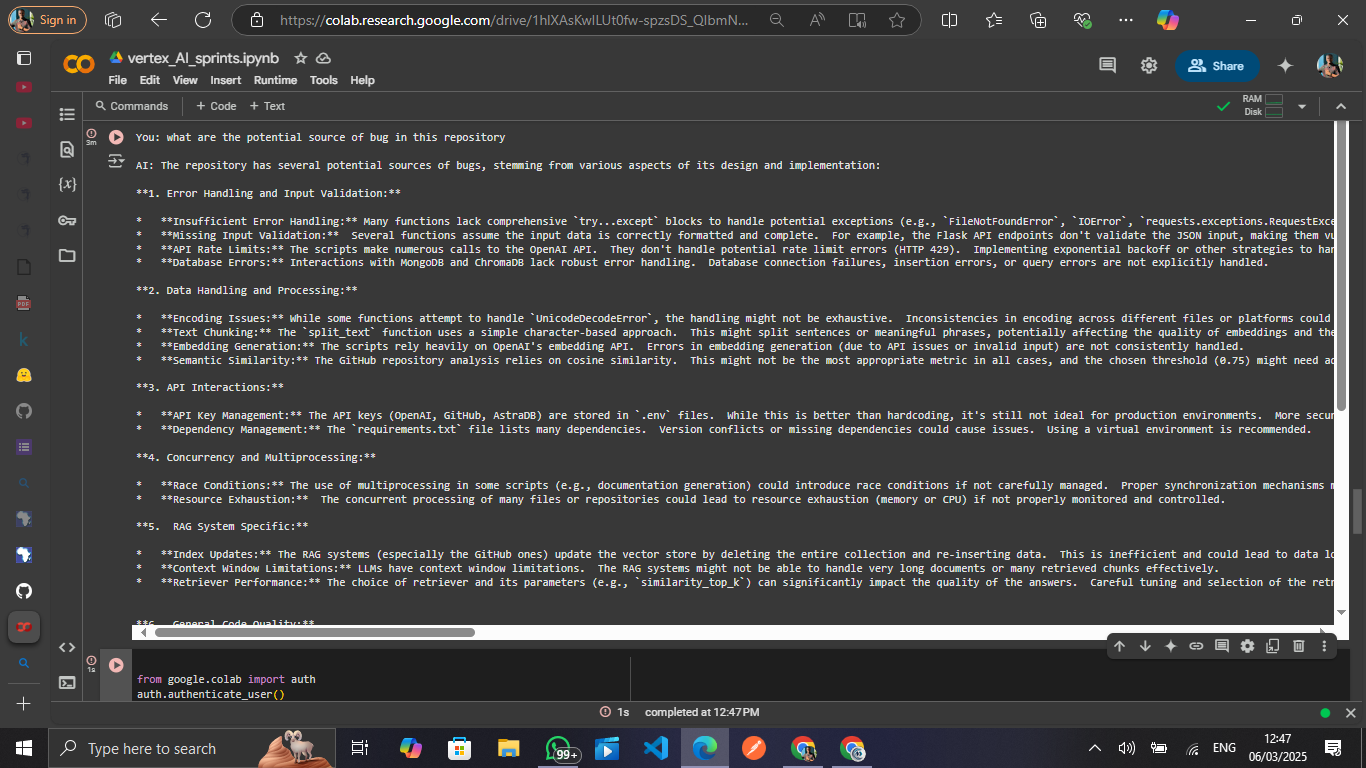

In [ ]:
# Step 0: Install required packages
!pip install google-cloud-aiplatform google-cloud-documentai pandas gradio
!pip install --upgrade --user --quiet google-genai gitingest gitpython PyGithub
!pip install google-cloud-aiplatform vertexai PyPDF2 pandas matplotlib requests python-dotenv

In [ ]:
import google.generativeai as genai
import os
import json
import requests
import vertexai
import pandas as pd
from PyPDF2 import PdfReader
from typing import Dict, Any, Optional
from vertexai.generative_models import GenerativeModel
from vertexai.preview.generative_models import GenerativeModel as PreviewGenerativeModel
from google.cloud import aiplatform
from google.oauth2 import service_account
from googleapiclient.discovery import build

In [ ]:
# Initialize Vertex AI
# Set Google Cloud project information
PROJECT_ID =  "your-project-id"
LOCATION = "your project location"

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
def authenticate_drive():
    """
    Authenticate and create a Google Drive service instance.

    Returns:
        googleapiclient.discovery.Resource: Authenticated Google Drive service instance
    """
    try:
        credentials = service_account.Credentials.from_service_account_file(
            os.getenv("GOOGLE_APPLICATION_CREDENTIALS"),
            scopes=["https://www.googleapis.com/auth/drive"]
        )
        drive_service = build('drive', 'v3', credentials=credentials)
        print("Google Drive authenticated successfully.")
        return drive_service
    except Exception as e:
        print(f"Error authenticating Google Drive: {e}")
        raise

In [ ]:
def list_drive_files(drive_service, query: str = "") -> Dict[str, Any]:
    """
    List files in Google Drive based on a query.

    Args:
        drive_service (googleapiclient.discovery.Resource): Authenticated Google Drive service instance
        query (str): Query string to filter files (optional)

    Returns:
        Dict[str, Any]: A dictionary containing file information
    """
    try:
        results = drive_service.files().list(q=query, pageSize=10, fields="files(id, name)").execute()
        items = results.get('files', [])
        if not items:
            print("No files found.")
            return {"files": []}
        else:
            print("Files found:")
            for item in items:
                print(f"{item['name']} ({item['id']})")
            return {"files": items}
    except Exception as e:
        print(f"Error listing files in Google Drive: {e}")
        raise

# Example usage
drive_service = authenticate_drive()
files = list_drive_files(drive_service, query="mimeType='application/pdf'")

In [ ]:
# 1. Email Draft Generation
def initialize_email_model():
    """
    Initialize and return the Gemini Flash model for email-related tasks.

    Returns:
        GenerativeModel: Initialized Gemini Flash model
    """
    try:
        model = GenerativeModel("gemini-flash")
        print("Email model initialized successfully.")
        return model
    except Exception as e:
        print(f"Error initializing email model: {e}")
        raise

In [ ]:
def analyze_email(email_content: str) -> Dict[str, Any]:
    """
    Analyze an email to extract key information and determine its context and priority.

    Args:
        email_content (str): The full content of the email including headers and body

    Returns:
        Dict[str, Any]: A dictionary containing extracted email information
    """
    model = initialize_email_model()

    prompt = f"""
    Analyze the following email and extract key information.
    Provide the result as a JSON object with the following keys:
    - sender: The email sender
    - subject: The email subject
    - body: The cleaned email body without headers or signatures
    - priority: Determined priority (high, medium, low)
    - category: Determined category (e.g., inquiry, support, collaboration, scheduling)
    - key_points: List of key points that should be addressed in the response
    - tone: The appropriate tone for a response (e.g., formal, friendly, urgent)

    EMAIL:
    {email_content}

    JSON RESPONSE:
    """

    response = model.generate_content(prompt)

    try:
        json_str = response.text
        if "```json" in json_str:
            json_str = json_str.split("```json")[1].split("```")[0].strip()
        elif "```" in json_str:
            json_str = json_str.split("```")[1].split("```")[0].strip()

        email_analysis = json.loads(json_str)
        return email_analysis
    except Exception as e:
        print(f"Error parsing email analysis: {e}")
        print(f"Raw response: {response.text}")
        return {
            "sender": "Unknown",
            "subject": "Unknown",
            "body": email_content,
            "priority": "medium",
            "category": "general",
            "key_points": ["Address the sender's message"],
            "tone": "professional"
        }

In [ ]:
def generate_email_draft(email_analysis: Dict[str, Any], user_context: Optional[Dict[str, Any]] = None) -> str:
    """
    Generate a draft email response based on email analysis and user context.

    Args:
        email_analysis (Dict[str, Any]): The analysis output from analyze_email()
        user_context (Dict[str, Any], optional): Additional context about the user

    Returns:
        str: A draft email response
    """
    model = initialize_email_model()

    if user_context is None:
        user_context = {
            "name": "Team Member",
            "role": "Professional",
            "communication_style": "Professional and concise",
            "signature": "Best regards,\nTeam Member"
        }

    prompt = f"""
    Draft a response to the following email, addressing all key points while maintaining the appropriate tone.

    EMAIL ANALYSIS:
    Sender: {email_analysis['sender']}
    Subject: {email_analysis['subject']}
    Priority: {email_analysis['priority']}
    Category: {email_analysis['category']}

    ORIGINAL EMAIL BODY:
    {email_analysis['body']}

    KEY POINTS TO ADDRESS:
    {', '.join(email_analysis['key_points'])}

    RESPONSE TONE: {email_analysis['tone']}

    RESPONDER CONTEXT:
    Name: {user_context['name']}
    Role: {user_context['role']}
    Communication Style: {user_context['communication_style']}

    Draft a complete, well-formatted email response that addresses all key points.
    Do not include any explanations outside the email draft.
    Include an appropriate subject line and sign with the provided signature.
    """

    response = model.generate_content(prompt)
    return response.text.strip()

In [ ]:


def email_draft_workflow(email_content: str, user_context: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    """
    Complete workflow for email draft generation.

    Args:
        email_content (str): The full content of the email
        user_context (Dict[str, Any], optional): Additional context about the user

    Returns:
        Dict[str, Any]: A dictionary containing the email analysis and draft response
    """
    analysis = analyze_email(email_content)
    draft = generate_email_draft(analysis, user_context)

    return {
        "analysis": analysis,
        "draft_response": draft
    }

In [ ]:
import os
import shutil

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display
import git
from github import Github
from gitingest import ingest

InteractiveShell.ast_node_interactivity = "all"

from google.genai.types import CreateCachedContentConfig, GenerateContentConfig
import nest_asyncio

nest_asyncio.apply()

In [ ]:
# Set Google Cloud project information
PROJECT_ID =  "your-project-id"
LOCATION = "your project location"

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)


In [ ]:
# The GitHub repository URL
repo_url = ""  # @param {type:"string"}

# The location to clone the repo
repo_dir = "./repo"

In [ ]:
def clone_repo(repo_url: str, repo_dir: str) -> None:
    """Shallow clone a GitHub repository."""
    if os.path.exists(repo_dir):
        shutil.rmtree(repo_dir)
    os.makedirs(repo_dir, exist_ok=True)
    git.Repo.clone_from(repo_url, repo_dir, depth=2)

In [ ]:
def get_github_issue(owner: str, repo: str, issue_number: int) -> str | None:
    """
    Fetch the contents of a GitHub issue.

    Args:
        owner (str): The owner of the repository.
        repo (str): The name of the repository.
        issue_number (int): The issue number to retrieve.

    Returns:
        str | None: The issue body if found, otherwise None.

    Raises:
        Exception: If an error occurs while fetching the issue.
    """
    g = Github()

    try:
        repository = g.get_repo(f"{owner}/{repo}")
        issue = repository.get_issue(number=issue_number)
        return issue.body
    except Exception as error:
        print(f"Error fetching issue: {error}")
        return None

In [ ]:
def get_git_diff(repo_dir: str) -> str:
    """Fetches commit IDs from a local Git repository on a specified branch."""
    repo = git.Repo(repo_dir)
    branch_name = "main"

    # A list of commit IDs (SHA-1 hashes) in reverse chronological order (newest first)
    commit_ids = [commit.hexsha for commit in repo.iter_commits(branch_name)]
    if len(commit_ids) >= 2:
        return repo.git.diff(commit_ids[0], commit_ids[1])
    return ""

In [ ]:
clone_repo(repo_url, repo_dir)

exclude_patterns = {
    "*.png",
    "*.jpg",
    "*.jpeg",
    "*.gif",
    "*.svg",
    "*.ico",
    "*.webp",
    "*.jar",
    ".git/",
    "*.gitkeep",
}
_, tree, content = ingest(repo_dir, exclude_patterns=exclude_patterns)

In [ ]:
tree

'Directory structure:\n└── repo/\n    ├── Readme.md\n    ├── 3o_mini.md\n    ├── GENERAL_DOCUMENTATION.md\n    ├── endpoint_.md\n    ├── endpoint_.py\n    ├── gen_docs_generator 3o model.md\n    ├── gen_docs_generator 3o model.py\n    ├── gen_docs_generator.md\n    ├── gen_docs_generator.py\n    ├── generate_python_docs.md\n    ├── generate_python_docs.py\n    ├── main.ipynb\n    ├── project_workflow.ipynb\n    ├── requirements.txt\n    ├── test_aniebiet.md\n    ├── test_aniebiet.py\n    ├── OpenAI-DeepSeek-RAG/\n    │   ├── deepseek_md.ipynb\n    │   ├── deepseek_pdf.ipynb\n    │   ├── deepseek_pdf_ui.md\n    │   ├── deepseek_pdf_ui.py\n    │   ├── openai_main.ipynb\n    │   ├── openai_main.md\n    │   ├── openai_main.py\n    │   ├── openai_ui.md\n    │   ├── openai_ui.py\n    │   ├── requirements.txt\n    │   ├── chroma_persistent_storage/\n    │   │   ├── chroma.sqlite3\n    │   │   └── a6ed04eb-cfcc-4ce7-b819-f38d639f71d4/\n    │   │       ├── data_level0.bin\n    │   │       ├── h

In [ ]:
content

'================================================\nFile: Readme.md\n================================================\n# Project Workflow Documentation\n\nThis documentation provides a detailed overview of the code and instructions on how to use it. The code is a Flask application that integrates with MongoDB and OpenAI\'s GPT model to manage a project workflow.\n\n![API calls](image.png)\n*Figure 1: API calls*\n## Table of Contents\n\n1. [Introduction](#introduction)\n2. [Prerequisites](#prerequisites)\n3. [Installation](#installation)\n4. [Configuration](#configuration)\n5. [Usage](#usage)\n6. [Endpoints](#endpoints)\n7. [Code Explanation](#code-explanation)\n8. [Contributing](#contributing)\n9. [License](#license)\n\n## Introduction\n\nThis Flask application is designed to manage a project workflow by interacting with a MongoDB database and OpenAI\'s GPT model. It provides endpoints to initialize a project, ask questions, generate user stories, and generate development plans.\n\n## P

In [ ]:
MODEL_ID = "gemini-1.5-flash-002"  # @param {type:"string"}

In [ ]:
prompt = """You are a coding expert. Your mission is to answer all code related questions with given context and instructions.
    Context:
    - The entire codebase is provided below.
    - Here is directory tree of all of the files in the codebase:
    tree:
    - Then each of the files are concatenated together. You will find all of the code you need:
    """

In [ ]:
import google.generativeai as genai
from google.colab import userdata
import csv
import getpass

g_api_key = 'APi key'

genai.configure(api_key=g_api_key)

generation_config = {
  "temperature": 0.05,
  "top_p": 0.95,
  "top_k": 1 #https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#gemini-models
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_NONE"
  },
]

SYSTEM_PROMPT = prompt


content = f""" Tree : /n {tree} /n /n /n Content and code: /n {content}"""
USER_CODE = content

model = genai.GenerativeModel(model_name="gemini-1.5-flash-002",
                              generation_config=generation_config,
                              system_instruction=SYSTEM_PROMPT,
                              safety_settings=safety_settings)

convo = model.start_chat(history=[])


In [ ]:
convo

ChatSession(
    model=genai.GenerativeModel(
        model_name='models/gemini-1.5-flash-002',
        generation_config={'temperature': 0.05, 'top_p': 0.95, 'top_k': 1},
        safety_settings={<HarmCategory.HARM_CATEGORY_HARASSMENT: 7>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_HATE_SPEECH: 8>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: 9>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: 10>: <HarmBlockThreshold.BLOCK_NONE: 4>},
        tools=None,
        system_instruction='You are a coding expert. Your mission is to answer all code related questions with given context and instructions.\n    Context:\n    - The entire codebase is provided below.\n    - Here is directory tree of all of the files in the codebase:\n    tree:\n    - Then each of the files are concatenated together. You will find all of the code you need:\n    ',
        cached_content=None
    ),
    history=[]
)

In [ ]:
import time
import requests

def send_request_with_backoff(convo, message, max_retries=5):
    delay = 1  # Initial delay (in seconds)

    for attempt in range(max_retries):
        try:
            response = convo.send_message(message)
            return response.text  # Successful response
        except requests.exceptions.RequestException as e:
            if "429" in str(e):
                print(f"Rate limit hit. Retrying in {delay} seconds...")
                time.sleep(delay)
                delay *= 2  # Double the delay time
            else:
                print("Unexpected error:", e)
                break  # Exit loop for non-rate-limit errors
    return "Error: Too many requests. Try again later."

def chat_with_model():
    print("Welcome to the AI assistant! Type 'exit' to end the conversation.")

    isFirst = True
    while True:
        user_input = input("\nYou: ")

        if user_input.lower() == "exit":
            print("Goodbye!")
            break

        message = USER_CODE if isFirst else user_input
        isFirst = False

        response = send_request_with_backoff(convo, message)
        print("\nAI:", response)
        print("===================================================================================================")

if __name__ == '__main__':
    chat_with_model()


Welcome to the AI assistant! Type 'exit' to end the conversation.

You: hii

AI: The provided codebase is a collection of Python scripts and markdown documentation files related to a project that uses OpenAI's API for various tasks, including generating documentation, analyzing GitHub repositories, and building a question-answering system over markdown and PDF documents.  The project extensively uses Langchain and other libraries for efficient processing and interaction with external APIs.

Here's a summary of the key components and their functionalities:

**1. Documentation Generation:**

*   `generate_python_docs.py`: Generates markdown documentation for Python files using OpenAI's API.  It uses multiprocessing for speed.
*   `gen_docs_generator.py` and `gen_docs_generator 3o model.py`: Generate markdown documentation for markdown files using OpenAI's API. They also use multiprocessing.
*   `3o_mini.md` and `GENERAL_DOCUMENTATION.md`: Markdown files that serve as overviews of the pro

KeyboardInterrupt: Interrupted by user

# 2. Research Paper Summarization

In [ ]:
def initialize_research_model():
    """
    Initialize and return the Gemini Pro model for research paper summarization.

    Returns:
        GenerativeModel: Initialized Gemini Pro model
    """
    try:
        model = GenerativeModel("gemini-pro")
        print("Research paper model initialized successfully.")
        return model
    except Exception as e:
        print(f"Error initializing research paper model: {e}")
        raise

In [ ]:
def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extract text content from a PDF file.

    Args:
        pdf_path (str): Path to the PDF file

    Returns:
        str: Extracted text content
    """
    try:
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        raise

In [ ]:
def analyze_research_paper(paper_text: str) -> Dict[str, Any]:
    """
    Analyze a research paper to identify key sections and attributes.

    Args:
        paper_text (str): The full text content of the research paper

    Returns:
        Dict[str, Any]: A dictionary containing extracted paper information
    """
    model = initialize_research_model()

    max_chunk_size = 15000

    if (len(paper_text) > max_chunk_size):
        intro_chunk = paper_text[:max_chunk_size]

        intro_prompt = f"""
        Analyze the beginning of this research paper and extract the following information:
        - title: The paper's title
        - authors: List of authors
        - abstract: The paper's abstract
        - keywords: Any keywords listed

        Provide the result as a JSON object.

        PAPER TEXT (BEGINNING):
        {intro_chunk}
        """

        intro_response = model.generate_content(intro_prompt)

        chunks = [paper_text[i:i + max_chunk_size] for i in range(0, len(paper_text), max_chunk_size)]
        all_sections = {}

        for i, chunk in enumerate(chunks):
            chunk_prompt = f"""
            Analyze this section (chunk {i+1} of {len(chunks)}) of a research paper and identify any complete or partial sections it contains.
            For each identified section, extract its title and summarize its content briefly.

            Provide the result as a JSON object with section titles as keys and summaries as values.

            PAPER TEXT (CHUNK {i+1}):
            {chunk}
            """

            chunk_response = model.generate_content(chunk_prompt)

            try:
                chunk_json_str = chunk_response.text
                if "```json" in chunk_json_str:
                    chunk_json_str = chunk_json_str.split("```json")[1].split("```")[0].strip()
                elif "```" in chunk_json_str:
                    chunk_json_str = chunk_json_str.split("```")[1].split("```")[0].strip()

                chunk_sections = json.loads(chunk_json_str)
                all_sections.update(chunk_sections)
            except Exception as e:
                print(f"Error parsing chunk {i+1} response: {e}")
                print(f"Raw response: {chunk_response.text}")

        try:
            intro_json_str = intro_response.text
            if "```json" in intro_json_str:
                intro_json_str = intro_json_str.split("```json")[1].split("```")[0].strip()
            elif "```" in intro_json_str:
                intro_json_str = intro_json_str.split("```")[1].split("```")[0].strip()

            paper_info = json.loads(intro_json_str)
            paper_info["sections"] = all_sections

            conclusion_prompt = f"""
            Based on the research paper sections provided, identify:
            1. Key findings or results
            2. Main methodology used
            3. Limitations mentioned
            4. Future work suggestions

            Provide the result as a JSON object.

            PAPER SECTIONS:
            {json.dumps(all_sections)}
            """

            conclusion_response = model.generate_content(conclusion_prompt)

            conclusion_json_str = conclusion_response.text
            if "```json" in conclusion_json_str:
                conclusion_json_str = conclusion_json_str.split("```json")[1].split("```")[0].strip()
            elif "```" in conclusion_json_str:
                conclusion_json_str = conclusion_json_str.split("```")[1].split("```")[0].strip()

            conclusion_info = json.loads(conclusion_json_str)
            paper_info.update(conclusion_info)

            return paper_info

        except Exception as e:
            print(f"Error integrating paper analysis: {e}")
            return {
                "title": "Unknown",
                "authors": ["Unknown"],
                "abstract": "Abstract extraction failed",
                "sections": all_sections,
                "key_findings": ["Extraction failed"],
                "methodology": "Methodology extraction failed"
            }
    else:
        prompt = f"""
        Analyze the following research paper and extract key information.
        Provide the result as a JSON object with the following keys:
        - title: Paper title
        - authors: List of authors
        - abstract: Paper abstract
        - sections: Dict of identified sections and their content summaries
        - key_findings: List of key findings
        - methodology: Description of methodology used
        - limitations: Any limitations mentioned
        - future_work: Suggestions for future work

        PAPER TEXT:
        {paper_text}
        """

        response = model.generate_content(prompt)

        try:
            json_str = response.text
            if "```json" in json_str:
                json_str = json_str.split("```json")[1].split("```")[0].strip()
            elif "```" in json_str:
                json_str = json_str.split("```")[1].split("```")[0].strip()

            paper_info = json.loads(json_str)
            return paper_info
        except Exception as e:
            print(f"Error parsing paper analysis: {e}")
            print(f"Raw response: {response.text}")
            return {
                "title": "Unknown",
                "authors": ["Unknown"],
                "abstract": "Abstract extraction failed",
                "sections": {},
                "key_findings": ["Extraction failed"],
                "methodology": "Methodology extraction failed"
            }

In [ ]:
def generate_research_summary(paper_analysis: Dict[str, Any], summary_type: str = "comprehensive") -> str:
    """
    Generate a research paper summary based on the paper analysis.

    Args:
        paper_analysis (Dict[str, Any]): The analysis output from analyze_research_paper()
        summary_type (str): Type of summary to generate - options are:
            - "brief": 1-2 paragraph executive summary
            - "comprehensive": Detailed summary covering all sections
            - "technical": Focus on methodology and results for technical audience

    Returns:
        str: A formatted research paper summary
    """
    model = initialize_research_model()

    if summary_type == "brief":
        prompt = f"""
        Create a brief executive summary (1-2 paragraphs) of the following research paper.
        The summary should highlight the main objective, key methods, most important findings, and significance.

        PAPER INFORMATION:
        Title: {paper_analysis.get('title', 'Unknown')}
        Authors: {', '.join(paper_analysis.get('authors', ['Unknown']))}
        Abstract: {paper_analysis.get('abstract', 'Not available')}
        Key Findings: {', '.join(paper_analysis.get('key_findings', ['Not available']))}

        Format the summary as a concise, professional executive brief.
        """
    elif summary_type == "technical":
        prompt = f"""
        Create a technical summary of the following research paper focusing on methodology, results, and technical contributions.
        The summary should be suitable for an audience familiar with the field.

        PAPER INFORMATION:
        Title: {paper_analysis.get('title', 'Unknown')}
        Authors: {', '.join(paper_analysis.get('authors', ['Unknown']))}
        Abstract: {paper_analysis.get('abstract', 'Not available')}
        Methodology: {paper_analysis.get('methodology', 'Not available')}
        Sections: {json.dumps(paper_analysis.get('sections', {}))}
        Key Findings: {', '.join(paper_analysis.get('key_findings', ['Not available']))}
        Limitations: {paper_analysis.get('limitations', 'Not mentioned')}

        Format the summary with appropriate headings and structure for a technical audience.
        Include specific details on methods, experimental design, and results.
        """
    else:
        prompt = f"""
        Create a comprehensive summary of the following research paper.
        The summary should cover all main sections of the paper including introduction, methodology, results, discussion, and conclusion.

        PAPER INFORMATION:
        Title: {paper_analysis.get('title', 'Unknown')}
        Authors: {', '.join(paper_analysis.get('authors', ['Unknown']))}
        Abstract: {paper_analysis.get('abstract', 'Not available')}
        Sections: {json.dumps(paper_analysis.get('sections', {}))}
        Key Findings: {', '.join(paper_analysis.get('key_findings', ['Not available']))}
        Methodology: {paper_analysis.get('methodology', 'Not available')}
        Limitations: {paper_analysis.get('limitations', 'Not mentioned')}
        Future Work: {paper_analysis.get('future_work', 'Not mentioned')}

        Format the summary with appropriate headings for each major section.
        The summary should be well-structured and maintain the logical flow of the original paper.
        """

    response = model.generate_content(prompt)
    return response.text.strip()

In [ ]:
def research_summary_workflow(pdf_path: str, summary_type: str = "comprehensive") -> Dict[str, Any]:
    """
    Complete workflow for research paper summarization.

    Args:
        pdf_path (str): Path to the PDF file of the research paper
        summary_type (str): Type of summary to generate (brief, comprehensive, technical)

    Returns:
        Dict[str, Any]: A dictionary containing the paper analysis and generated summary
    """
    paper_text = extract_text_from_pdf(pdf_path)
    analysis = analyze_research_paper(paper_text)
    summary = generate_research_summary(analysis, summary_type)

    return {
        "paper_info": analysis,
        "summary": summary,
        "summary_type": summary_type
    }

# 3. Code Visualization

In [ ]:
imagen_model = "imagen-3.0-generate-002"

In [ ]:
def initialize_imagen_model():
    """
    Initialize and return the Imagen model for generating visualizations.

    Returns:
        PreviewGenerativeModel: Initialized Imagen model
    """
    try:
        model = PreviewGenerativeModel("imagegeneration@002")
        print("Imagen model initialized successfully.")
        return model
    except Exception as e:
        print(f"Error initializing Imagen model: {e}")
        raise

In [ ]:
prompt = """
Create a detailed visual representation of an AI-powered workflow automation system.
Include structured elements such as process flow diagrams, interconnected AI components
(Vertex AI, Gemini, Imagen API), and their roles in email drafting, research paper summarization,
image generation, codebase interaction, and Google Drive file management. Ensure clarity, efficiency,
and visually appealing design to enhance workflow understanding

"""

In [ ]:
def generate_image(prompt: str):
    """
    Generate an image based on the given prompt using Google's Imagen model.

    Args:
        prompt (str): The text description for the image to generate.

    Returns:
        dict: The generated image response containing the image URL or base64 data.
    """
    try:
        model = initialize_imagen_model()
        response = model.generate_content(
            prompt,
            generation_config={"response_mime_type": "image/png"}
        )
        image_data = response.candidates[0].content.parts[0].data
        print("Image generated successfully.")
        return {"image_data": image_data}
    except Exception as e:
        print(f"Error generating image: {e}")
        raise

Step 7: Integrating Everything with a Helper Function
Why this is needed:
Instead of running individual functions, this helper function allows users to call multiple AI tasks through a single function, based on the task type.

In [ ]:
def execute_ai_task(task, input_text):
    if task == "email_draft":
        return generate_email_draft(input_text)
    elif task == "summarize_paper":
        return summarize_research_paper(input_text)
    elif task == "generate_visual":
        return generate_visual(input_text)
    elif task == "chat_codebase":
        return chat_with_codebase(input_text.split("\n---\n")[0], input_text.split("\n---\n")[1])
    else:
        return "Invalid task specified."


Final Thoughts & Next Steps
What we have built:
We successfully developed an AI Workflow Automation Agent using Google Cloud’s Vertex AI, Gemini, and Imagen API. This AI-powered agent can:
✅ Draft emails automatically.
✅ Summarize research papers into concise insights.
✅ Generate AI-powered visuals based on text prompts.
✅ Assist developers in understanding and debugging code.


What’s Next?
Deploy as a Google Cloud Function: Make the AI agent available via API.
Integrate with Google Workspace: Automate tasks in Gmail, Docs, and Calendar.
Enhance UI with a Web Interface: Create a frontend to interact with the AI agent easily.
Expand AI Capabilities: Add more automation features such as speech-to-text and workflow recommendations.


Conclusion
We successfully built an AI Workflow Automation Agent using Google Cloud’s Vertex AI, Gemini, and Imagen API. This AI agent can:

Generate email drafts to improve communication.
Summarize research papers for quicker insights.
Create AI-generated visuals to enhance presentations and reports.
Chat with a codebase to navigate, debug, and optimize code.
Authenticate and manage files in Google Drive for seamless automation.
By leveraging Google Cloud AI, we can build smarter workflows that drive efficiency and innovation in modern workplaces.

For access to the full code and implementation details, visit our GitHub or Colab repository:

🔗 GitHub Repository: https://github.com/Victorasuquo/vertex_aI-sprint

🔗 Google Colab Notebook: https://colab.research.google.com/drive/1hlXAsKwILUt0fw-spzsDS_QIbmNZm7yn?usp=sharing

References:

Google Cloud Vertex AI
Google Gemini AI: https://ai.google.dev/
Google Imagen API: https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview
#AI #MachineLearning #VertexAI #GoogleCloud #Automation #AIWorkflow #GenerativeAI #Productivity #CodeAutomation #ImagenAPI #GeminiAI #Python #TechInnovation #AIResearch #CloudComputing #APIAutomation #GoogleAI #DeepLearning #AIForDevelopers #ArtificialIntelligence #DataScience #NLP #ComputerVision